First install the repo and requirements.

In [ ]:
%pip --quiet install git+https://github.com/wilson-labs/cola.git

# Boundary Value PDEs

In this example we will show how CoLA can be used to solve linear and nonlinear boundary value PDEs.

## Laplace Equation $\Delta u = 0$

For this example we will solve the Laplace equation on an irregularly shaped domain with given boundary conditions using a finite difference discretization.

First lets create a 1000 x 1000 point coordinate mesh.

In [1]:
import numpy as np
import jax.numpy as jnp
import scipy
import jax


N=1000
ndims = 2

xgrid = jnp.linspace(-1,1,N)
xygrid = jnp.stack(jnp.meshgrid(*(ndims*[xgrid])),axis=-1)
dx = xgrid[1]-xgrid[0]
x,y = xygrid.transpose((2,0,1))

With the mesh, lets define the geometry of the PDE domain and boundary conditions. The domain need not be square as shown below. For boundary conditions, we will set them to be $B(x,y) = (x+y)\cos(2x)$ on the boundary of this domain.

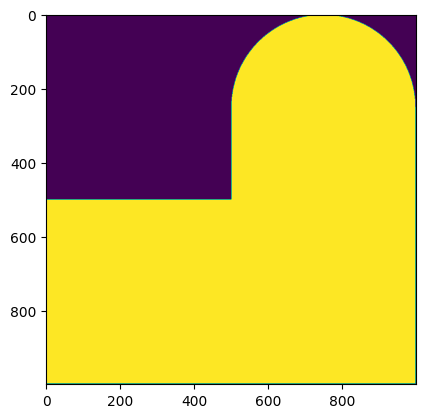

In [2]:
domain = (((x>0)|(y>0))&((y>-.5)|((x-.5)**2+(y+.5)**2<.5**2))) # chosen for example
# reduce the domain by one pixel leave space for the boundary conditions
domain &= ~(scipy.signal.convolve2d((~domain).astype(np.float32),jnp.ones((3,3)),mode='same',fillvalue=1)>0)
domain_ids, = domain.reshape(-1).nonzero()

BCS = jnp.where(domain,jnp.zeros_like(x),(x+y)*jnp.cos(2*x))


import matplotlib.pyplot as plt
plt.imshow(domain)
plt.show()


Now we need to define the Laplacian $\Delta$ as it acts on this discretized domain. 
Supposing we have the two dimensional array $v[i,j]$ representing the values on the grid, we can use the centered difference stencil for second derivatives $\partial_x^2 v(x_i,y_j) = (v[i+1, j] - 2*v[i, j] + v[i-1, j])/h^2$ + O(h^3)$.

Equivalently, we can write this as a convolution $\partial_x^2 v(x_i,y_j) =(1/h^2) (\begin{bmatrix}1& -2 &1\end{bmatrix} * v)[i,j] + O(h^3)$ where $*$ is the discrete convolution. The discretized 2d Laplacian is therefore

$Lv = (\begin{bmatrix}1& -2 &1\end{bmatrix} * v + \begin{bmatrix} 1 \\ -2 \\ 1 \end{bmatrix} *v)/h^2$. 

From this matrix vector multiply, we can define the linear operator using CoLA.

In [3]:
import cola
from jax import vmap, jit

def laplacian(x):
    x = x.reshape(ndims*(N,)) # unflatten to an ndims-dimensional grid
    cderiv = lambda x: jax.scipy.signal.correlate(x,jnp.array([1.,-2,1.])/dx**2,mode='same')
    return sum([jnp.apply_along_axis(cderiv,i,x) for i in range(ndims)]).reshape(-1)

Lfull = cola.LinearOperator(jnp.float32,shape=(N**ndims,N**ndims),matmat=jit(vmap(laplacian,-1,-1)))
Lfull = cola.PSD(Lfull)

Lfull is defined on the full $1000 \times 1000$ grid rather than our irregularly shaped domain. Restrict it to the domain, we just need to select the indices of the points inside the domain by slicing it, as you would a matrix.

In [4]:
L = Lfull[domain_ids,domain_ids]

Since this would ignore the boundary conditions, we can simply add them in on the right hand side.

In [5]:
RHS = -(Lfull@BCS.reshape(-1))[domain_ids]

Finally, let's solve the linear system represented by this discretized laplacian and the boundary conditions

$Lv = b$

and annotate that $L$ is a symmetric operator to speed up the computation.

In [6]:
L = cola.PSD(L)
inv = cola.inverse(L,pbar=True)
v  = inv@RHS

Running body_fun:   0%|          | 0/100 [00:00<?,?it/s]

Though we need to invert a $1000000 \times 1000000$ sized matrix, the solution is produced very quickly because CoLA never forms the matrix explicitly, and we can visualize the solution below.

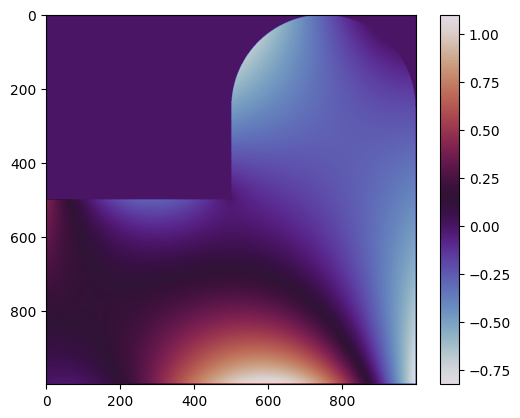

In [7]:
out_img = jnp.zeros(domain.shape)
out_img = out_img.at[domain].set(v)

plt.imshow(out_img,cmap='twilight')
plt.colorbar()
plt.show()

## Nonlinear BVP: Minimal Surface Equation

In this example we will consider solving the minimal surface equation, and example of a nonlinear boundary value PDE describing the shape of a soap bubble with a fixed boundary.
For the minimal surface, we would like to solve for the height $z$ of the surface at each point $(x,y)$ on the domain, and we make the assumption that the height is single valued.

The PDE is given by

$(1+z_x^2)z_{yy} - 2z_x z_y z_{xy} + (1+z_y^2)z_{xx}=0$

 where subscripts denote partial derivatives.
We will solve the PDE on the domain $[-1,1]^2$ with the boundary conditions

$z(x,\pm 1) = 1-x^2$ and $z(\pm 1, y) = 0$.

Before solving, first we will define the mesh and the nonlinear pde constraint.

In [8]:
N=50
xgrid = jnp.linspace(-1,1,N)
xygrid = jnp.stack(jnp.meshgrid(xgrid,xgrid),axis=-1)
dx = xgrid[1]-xgrid[0]

def pde_constraint(z):
    deriv = lambda x: jax.scipy.signal.correlate(x,jnp.array([-1/2,0,1/2])/dx,mode='same')
    deriv2 = lambda x: jax.scipy.signal.correlate(x,jnp.array([1.,-2,1.])/dx**2,mode='same')
    zx,zy = [jnp.apply_along_axis(deriv,i,z) for i in [0,1]]
    zxx,zyy = [jnp.apply_along_axis(deriv2,i,z) for i in [0,1]]
    zxy  = jnp.apply_along_axis(deriv,1,zx)
    return (1+zx**2)*zyy-2*zx*zy*zxy+(1+zy**2)*zxx

x,y = xygrid.transpose((2,0,1))
domain = (jnp.abs(x)<1)&(jnp.abs(y)<1)
boundary_vals = np.zeros_like(x)
boundary_vals[:,0] = 1-y[:,0]**2
boundary_vals[:,-1] = 1-y[:,-1]**2

@jit
def pde_constraint_on_domain(u):
    padded_domain = jnp.zeros(boundary_vals.shape)+boundary_vals
    padded_domain = padded_domain.at[domain].set(u.reshape(-1))
    padded_domain = pde_constraint(padded_domain)
    return padded_domain[domain].reshape(u.shape)

Now that we have defined the PDE constraint discretized on the domain,
we can now interpret the problem as finding the roots to a nonlinear function
$F(z)=0$ where $F$ is the discretized PDE constraint, and $z$ is a vector representing the heights at the different points on the domain.

To find the roots, we can employ Newtons method:

$z \gets z - J^{-1} F(z)$

where $J$ is the Jacobian of $z$.
While $J$ will be a large $N^2 \times N^2$ matrix, with CoLA we can perform this solve efficiently. For this we will use the CoLA [Jacobian](https://CoLA.readthedocs.io/en/latest/package/cola.ops.html#cola.ops.Jacobian) LinearOperator.

In [10]:
# Newton Raphson iteration
tol = 3e-3

z = jnp.zeros_like(x[domain]).reshape(-1) # initial guess
err = np.inf
while err > tol:
    F = pde_constraint_on_domain(z)
    err = jnp.max(jnp.abs(F))
    J = cola.ops.Jacobian(pde_constraint_on_domain,z)
    z -= cola.inverse(J, max_iters=100)@F
    print(f"PDE Error: {err:1.1e}")

PDE Error: 6.0e+02
PDE Error: 2.1e+02
PDE Error: 8.9e+01
PDE Error: 1.9e+01
PDE Error: 2.2e+00
PDE Error: 1.5e-01
PDE Error: 9.0e-04


Now let's visualize the results.

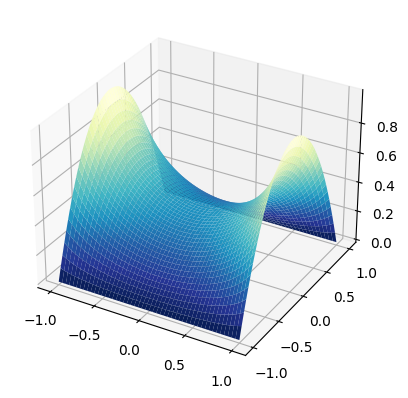

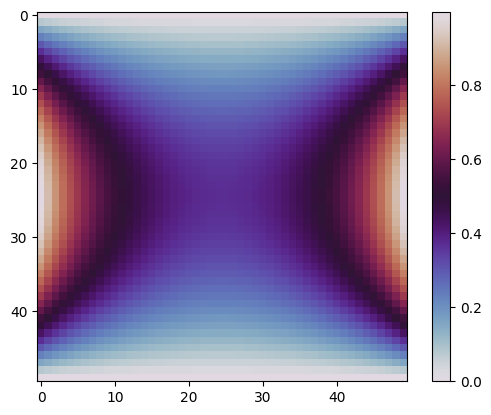

In [11]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
img = jnp.zeros(boundary_vals.shape)+boundary_vals
img = img.at[domain].set(z)
ax.plot_surface(x, y, img, cmap=plt.cm.YlGnBu_r)
plt.show()

plt.imshow(img,cmap='twilight')
plt.colorbar()
plt.show()

We see the minimal surface forms a familiar saddle shape, a solution of negative curvature like other solutions to the minimal surface equation.